<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_7_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 6: Inferencia estadística

En este clase vamos a dar los primeros pasos en lo que es comunmente llamado "Ajuste o calibración de modelos". Es decir, estimar parámetros de modelos de generación de datos a partir de observaciones.

A nivel general, el problema es hayar la probabilidad de que una variable $X$ tome determinado valor $k$ (en el caso de continuas, la densidad de probabilidad) dado los datos medidos:

$$p(X= k|\mathbf{x})$$

Noten, es una probabilidad **condicionada a los datos medidos**

Para eso, tenenemos que **proponer** un modelo para los datos. ¿Vendrán de una Normal? ¿Una Poisson? ¿una Gumbel? Este modelo de datos se identifica como (por ejemplo, para una Poisson):

$$X \sim Poisson(\lambda)$$

Es decir que, en mi modelo, la probabilidad de que $X$ tome un valor $k$ **dado** $\lambda$ es:

$$p(X=k|\lambda)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

También es una probabilidad **condicionada al parámetro**

La pregunta es, entonces, cómo encuentro lo primero? Bueno, primero, recordando que:

$$p(X=\mathbf{x}|\lambda)=\prod_{i=1}^{n_{x}} \frac{\lambda^{x_{i}}e^{-\lambda}}{x_{i}!}$$

Es decir, la probabilidad de los datos dado el parámetro es el producto de las probabilidades de cada uno (son independientes). Y, después, que el teorema de Bayes me permite **invertir** la condicionalidad:

$$p(\lambda|\mathbf{x}) = \frac{p(X=\mathbf{x}|\lambda)\ p(\lambda)}{\int p(X=\mathbf{x}|\lambda)\ p(\lambda)\ d\lambda}$$

Noten, entonces, que uno puede obtener entonces **la función de distribución de probabilidad del parámetro de mi modelo** condicionada a los datos medidos en función de 2 cosas:
1. La verosimilitud (la información que me dan los datos)
2. Mi conocimiento a priori del parámetro (lo que se antes de tener datos)

El denominador pueden pensarlo simplemente como una constante de integración necesaria para que me quede una función de densidad (con área unitaria).

¿Qué es lo que tengo entonces?

1. Propuse un modelo de donde vinieron los datos, lo que derivó en una función de Verosimilitud (la probabilidad de que los datos vengan de ese modelo con ese parámetro)
2. Propongo o tengo un conocimiento a priori del parámetro (transmitido a través de una función de distribución a priori)

¿Y a qué llego?

1. A una función de distribución posterior de los parámetros del modelo, aplicando el teorema de Bayes.

¿Qué faltaría? Encontrar finalmente el modelo para **predecir futuras observaciones**. Por el teorema de probabilidad total, esto resulta:

$$p(X= k|\mathbf{x}) = \int p(X=k|\lambda)\ p(\lambda|\mathbf{x})\ d\lambda$$

Obviamente, uno lo ve así y le dan un poco de miedo todas estas integrales. Pero no se preocupen, porque:
1. Algunos problemas sencillos tienen soluciones analíticas para las distribución posterior y predictiva
2. La simulación permite resolver las integrales "bastante fácil"
3. ¡A lo largo del curso usaremos librerías que lo van a hacer todo por nosotros!


**Nota adicional**: La distribución de Poisson puede escribirse también en función del intervalo de tiempo estudiado, ya que es arbitrario. Es decir, yo puedo analizar "Sismos por año" o "Sismos cada 50 años" para el mismo fenómeno. Entonces, fijando el intervalo de tiempo $\Delta t$ nos queda que:

$$p(X=k|\lambda,\Delta t)=\frac{\left(\lambda\, \Delta t\right)^{k}e^{-\left(\lambda\, \Delta t\right)}}{k!}$$

cuyo valor medio es $\bar{x}=\lambda\, \Delta t$, un valor adimensional (el conteo de eventos).

## Ejemplo 1: Sismos en San Juan (soluciones analíticas)

El primer ejemplo que vamos a seguir es el ajuste de un modelo para predecir el número de sismos en la Provincia de San Juan por año.

Para ello, descargamos de la página de [USGS](https://earthquake.usgs.gov/earthquakes/search/), los datos de los últimos 60 años.

### Limpieza de los datos (Off Road)

Para el que le interesa, a continuación les dejamos todo el proceso de convertir los datos descargados en algo "útil" para trabajar, tema que excede largamente a los objetivos del curso.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from google.colab import files

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving Sismos_SanJuan.csv to Sismos_SanJuan.csv


In [ ]:
#Se crea un DataFrame
df_sismos = pd.read_csv(io.BytesIO(uploaded['Sismos_SanJuan.csv']))
df_sismos.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-12-27T13:01:04.080Z,-31.2940,-69.3336,109.05,4.5,mb,NaN,66.0,0.609,0.77,...,2022-03-05T23:10:45.040Z,"9 km ENE of Calingasta, Argentina",earthquake,4.6,5.8,0.314,3.0,reviewed,us,us
1,2021-12-08T23:36:02.742Z,-31.8741,-68.3598,112.11,4.0,mb,NaN,115.0,0.288,1.04,...,2022-02-12T23:07:04.040Z,"22 km S of Nueve de Julio, Argentina",earthquake,8.2,4.3,0.184,8.0,reviewed,us,us
2,2021-11-25T03:18:30.863Z,-32.7200,-70.1864,112.84,4.0,mb,NaN,109.0,0.310,0.43,...,2022-01-29T22:55:53.040Z,"40 km ENE of Los Andes, Chile",earthquake,2.7,8.1,0.298,3.0,reviewed,us,us
3,2021-11-18T01:09:40.958Z,-31.2685,-69.0364,106.72,4.5,mb,NaN,47.0,0.408,0.65,...,2022-01-22T20:52:00.040Z,"37 km ENE of Calingasta, Argentina",earthquake,5.8,5.4,0.140,15.0,reviewed,us,us
4,2021-11-03T03:17:48.635Z,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,2022-01-14T17:58:56.040Z,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us


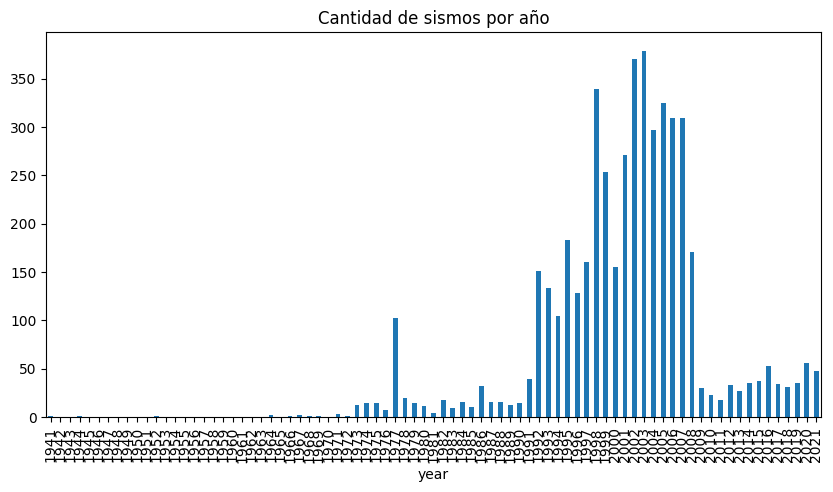

In [ ]:
# Convertir a datetime
df_sismos['time'] = pd.to_datetime(df_sismos['time'])

# Conteo por año
Data = df_sismos.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

¿Notan algo raro? ¿Cómo puede ser que haya explotado el número de sismos de repente?

Acá es donde entra en juego el conocimiento del fenómeno físico. Uno ve los datos de arriba y se ven claramente cuatro grandes regiones: Una hasta el 73, otra hasta el 92 y un último quiebre en la información en 2008.

Esto no es porque la sismicidad de San Juan haya cambiado significativamente en estos 50 años, sino que es una consecuencia de los cambios en la instrumentación de la región y los sismos que se informan y recolecta USGS.

Una forma fácil de chequear que el dataset así como está no sigue una distribución de poisson es si $\mu\not=\sigma^2$ (es una propiedad de la misma).

In [ ]:
# Chequear media y varianza
mu1 = df_sismos['time'].groupby(df_sismos["time"].dt.year).count().mean()
s1 = df_sismos['time'].groupby(df_sismos["time"].dt.year).count().var()
print('media',mu1)
print('varianza',s1)

media 83.10169491525424
varianza 12497.851548801871


¡Nada que ver! Pero esperá... pensemos cómo limpiar los datos.

1. Los datos anteriores a 1973 están claramente incompletos (no había datos)
2. Vamos a quedarnos sólo con los sismos "grandes" (mayores a Magnitud 5), porque los otros no se solían informar.

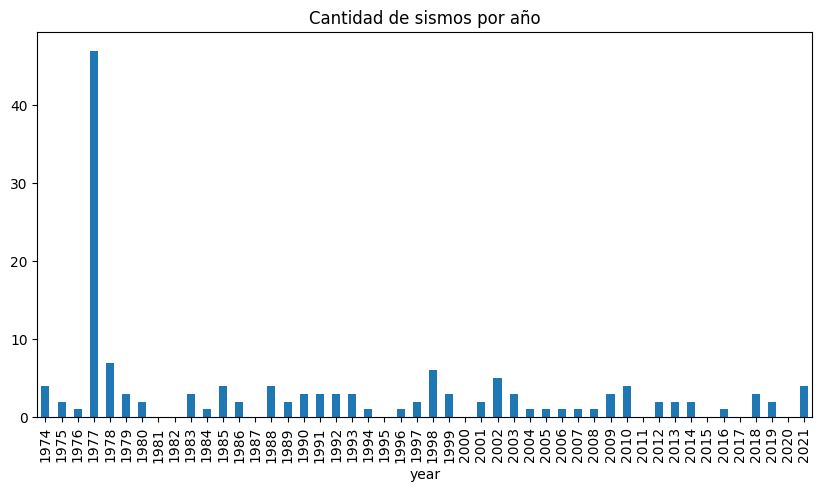

media 3.717948717948718
varianza 52.6288798920378


In [ ]:
## Filtrar datos anteriores a 1973 y con M < 5
Filter = (df_sismos['time']>pd.Timestamp('1973-01-01',tz='GMT+0'))*(df_sismos['mag']>5.)
df_sismosF = df_sismos[Filter]

# Conteo por año
Data = df_sismosF.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

# Chequear media y varianza
mu1 = df_sismosF['time'].groupby(df_sismosF["time"].dt.year).count().mean()
s1 = df_sismosF['time'].groupby(df_sismosF["time"].dt.year).count().var()
print('media',mu1)
print('varianza',s1)

¡Mejor! Pero sigue sin parecerse a una Poisson.

¿Pero no notan algo raro? ¿Qué pasó en San Juan en 1977?

¡Claro! El sismo de Caucete. Lo que estoy viendo ahí son **todas las réplicas**. Esos eventos no son independientes, tengo que eliminarlos. ¿Cómo?

Como este no es un curso de análisis sísmico, no entraremos al detalle de como filtrar el dataset, pero pueden encontrarlo en Gardner and Knopoff (1974). En resumen, se mira un ventana espacio-temporal que es función de la magnitud para generar un cluster de sismos, y aquel de mayor magnitud es el evento principal y resto son réplicas, eliminandose del dataset.

**Gardner, J. K., & Knopoff, L. (1974). Is the sequence of earthquakes in Southern California, with aftershocks removed, Poissonian?. Bulletin of the seismological society of America, 64(5), 1363-1367.*

In [ ]:
# Gardner Knopoff (1974)

# Distancia en base a latitud y longitud de 2 puntos
def distance_d(LaA, LaB, LoA, LoB):
  # Pasar a Radianes
  LoA = np.radians(LoA)
  LoB = np.radians(LoB)
  LaA= np.radians(LaA)
  LaB = np.radians(LaB)
  # "Haversine formula"
  D_Lo = LoB - LoA
  D_La = LaB - LaA
  P = np.sin(D_La / 2)**2 + np.cos(LaA) * np.cos(LaB) * np.sin(D_Lo / 2)**2
  Q = 2 * np.arcsin(np.sqrt(P))
  # Radio de la tierra en km
  R_km = 6371

  # Distancia en km
  return(Q * R_km)

# Valores de distancia y tiempo limites para chequear eventos
from scipy.interpolate import interp1d
M = np.linspace(2.5,8.0,12)
Tval = np.array([6,11.5,22,42,83,155,290,510,790,915,960,985])
Rval = np.array([19.5,22.5,26,30,35,40,47,54,61,70,81,94])

# Interpolacion lineal para otras magnitudes
Tthre = interp1d(M,Tval)
Rthre = interp1d(M,Rval)

# Inicializar una nueva columna que indique si es Main Shock (1) o no (2)
df_sismos['Main'] = np.zeros(df_sismos.shape[0])
# Iterar sobre los sismos
for i in range(df_sismos.shape[0]):
  # Chequear que no haya sido descartado por otra ventana
  if df_sismos['Main'][i] != 2:
    Mi = df_sismos['mag'][i] # Magnitud del sismo
    Ti = Tthre(Mi) # Ventana de tiempo
    Ri = Rthre(Mi) # Radio a considerar

    # Encontrar todos los sismos dentro de la ventana espacio-temporal
    Time = df_sismos['time'][i] # Dia del sismo i
    DeltaT = df_sismos['time'] - Time # Tiempo entre sismos
    DeltaT = DeltaT.dt.days # Tiempo en dias

    # Latitudes y Longitudes
    LaA = df_sismos['latitude'][i]
    LaB = df_sismos['latitude']
    LoA = df_sismos['longitude'][i]
    LoB = df_sismos['longitude']

    # Distancia entre epicentros
    Dist = distance_d(LaA,LaB,LoA,LoB)

    # Sismos a chequear
    FiltCheck = (np.abs(DeltaT)<Ti)*(Dist<Ri)

    # Verificar que califica como Main Shock
    if (Mi>=df_sismos['mag'][FiltCheck]).all() == True:
      # Descartar Cluster
      df_sismos['Main'][FiltCheck] = 2*np.ones(FiltCheck.shape)
      # Definir Main Shock
      df_sismos['Main'][i] = 1

<ipython-input-7-2716fb05ca2d>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sismos['Main'][FiltCheck] = 2*np.ones(FiltCheck.shape)
<ipython-input-7-2716fb05ca2d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sismos['Main'][i] = 1


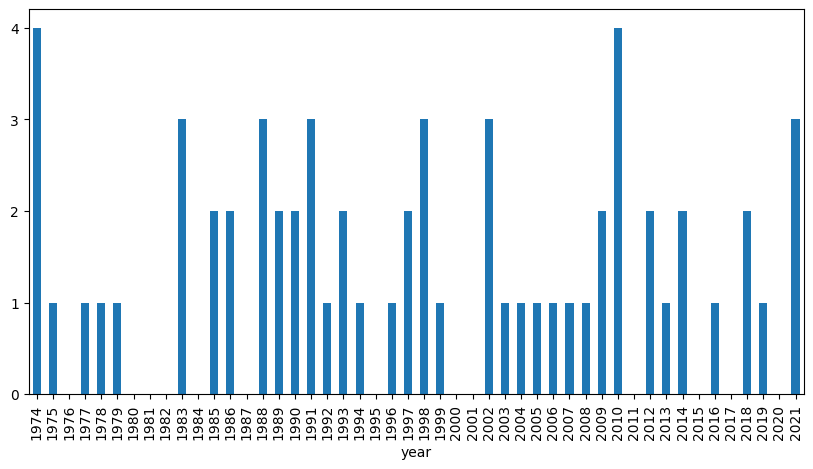

media 1.3125
varianza 1.2832446808510638


In [ ]:
# Definir Dataset filtrado final
FinalF = (df_sismos['Main'] == 1)*(df_sismos['mag']>5)*(df_sismos['time']>pd.Timestamp('1973-01-01',tz='GMT+0'))
df_sismosFinal = df_sismos[FinalF]

# Conteo por año
Data = df_sismosFinal.groupby(pd.Grouper(key='time', freq='Y')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar',yticks=[0,1,2,3,4], legend=False, figsize=(10,5))
#plt.title('xx')
plt.show()

# Chequear media y varianza
mu1 = Data['mag'].mean()
s2 = Data['mag'].var()
print('media',mu1)
print('varianza',s2)

Miren ahora como en 1977 en realidad solo hubo 1 sismo independiente. ¡Los otros 39 eran réplicas de ese!

Y noten ahora como estos datos filtrados efectivamente cumplen con una de las propiedades de la distribución de Poisson.

¡Nos faltaría chequear nada más que son independientes!

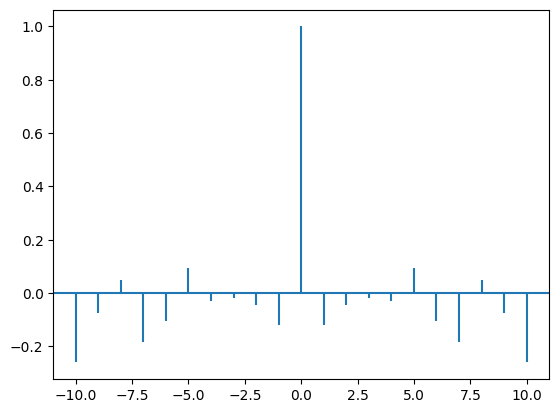

In [ ]:
# Autocorrelación
plt.acorr( Data['mag']-Data['mag'].mean() );

¡Efectivamente lo son! (O pareciera). Así que decir que el modelo que generó los datos es una distribución de Poisson es razonable.

### Modelo analítico

Los modelos de Poisson tienen solución análítica siempre y cuando se tome como distribución a priori una distribución Gamma (es una distribución a priori conjugada). Es decir, que si:

$$p(X=k|\lambda,\Delta t)=\frac{\left(\lambda\, \Delta t\right)^{k}e^{-\left(\lambda\, \Delta t\right)}}{k!}$$

y adopto como distribución a priori:

$$\lambda \sim \Gamma(\alpha, \beta)$$

Entonces la distribución posterior de $\lambda
$ será:

$$\lambda|\mathbf{x} \sim \Gamma(\alpha^{\prime}, \beta^{\prime})$$

Donde:

- $\alpha^{\prime}=\alpha+\sum_{i=1}^{n_{x}} x_{i}$ (Le sumo el total de eventos ocurridos).
- $\beta^{\prime} = \beta+\sum_{i=1}^{n_{x}} \Delta t_{i}$ (Le sumo el total de tiempo analizado).

Noten que puedo tener 50 datos de un año (si quiero calibrar sismos por año), o 1 dato de 50 años (si quiero calibrar sismos en 50 años). **Es lo mismo a fines prácticos**. Es más, los datos ni siquiera tienen que ser tomados en intervalos uniformes, sólo importa la suma total de eventos e intervalos para la inferencia.

A su vez, la predición de nuevos datos dentro un intervalo $\Delta t$ queda dada por:

$$X|\mathbf{x} \sim NB\left(\alpha^{\prime},\frac{\beta^{\prime}}{\Delta t+\beta^{\prime}}\right)$$

Es decir, una [Binomial Negativa](https://en.wikipedia.org/wiki/Negative_binomial_distribution)

#### Parámetros necesarios de los datos

Fijensé que tenemos todo! Primero, anotemos lo que necitamos extraer de los datos:

In [ ]:
# Numero de intervalos
sum_DT = len(Data)
print('El intervalo total es',sum_DT,'años')

# Cantidad de sismos totales
sum_xi = np.sum(Data['mag'])
print('La cantidad de sismos en el tiempo medido es',sum_xi)

El intervalo total es 48 años
La cantidad de sismos en el tiempo medido es 63


Y definamos, por ejemplo, que yo quiero el dato de sismos por año. Como el intervalo de tiempo está definido en años, esto logro tomando $\Delta t =1$

In [ ]:
# Intervalo de tiempo para predicciones
DT = 1
print('El dato de las predicciones lo quiero en un intervalo de',DT,'años')

El dato de las predicciones lo quiero en un intervalo de 1 años


#### Definición de los parámetros de la distribución a priori

Este tal vez es el punto más "dificil" a veces. Recuerden que la distribución a priori es la representación de lo que *nosotros* pensamos que es. En general, no sabemos nada... En esos casos dejamos "que los datos nos hablen", usando distribuciones a priori no-informativas.

Es decir, distribuciones que no meten ruido en la información que me dan los datos. Por ejemplo, vean los siguientes gráficos.

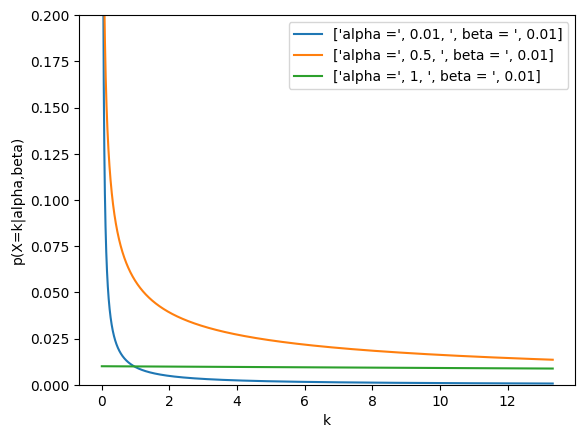

In [ ]:
# Soluciones analiticas
# ==============================================================================
import scipy.stats as st

alpha = [0.01, 0.5, 1]
beta = [0.01]

ki = np.array(range(10000))/750
for ai in alpha:
  for bi in beta:
    model = st.gamma(ai,scale=1/bi)
    pm = model.pdf(ki)
    name = ['alpha =',ai,', beta = ',bi]
    plt.plot(ki,pm,label=name)

plt.ylim([0,0.2])
plt.legend()
plt.xlabel('k')
plt.ylabel('p(X=k|alpha,beta)')
plt.show()
# ==============================================================================


##### Opción 1 (principio de indiferencia)

Se puede demostrar (y se ve en el gráfico) que si $\alpha = 1$ y $\beta → 0$ la distribución tiende a ser constante para todo valor no-negativo de $\lambda$. Es decir, le estaría asignando igual probabilidad a todos los valores posibles de $\lambda$.

$$p(\lambda) ∝ 1$$

Qué tan razonable es eso los dejo a su criterio (si me preguntan a mi, no es lógico pensar que la cantidad de sismos por año puede ser infinito o 3 con igual probabilidad)

Lo interesante, es que adoptando esto se llega a que:

$$\lambda|\mathbf{x} \sim \Gamma(1+\sum_{i=1}^{n_{x}} x_{i}, \sum_{i=1}^{n_{x}}\Delta t_{i})$$

cuyo valor más probable es:

$$\hat{\lambda} = \frac{\sum_{i=1}^{n_{x}} x_{i}}{\sum_{i=1}^{n_{x}} \Delta t_{i}}$$

nada más y nada menos que la definción del parámetro $\lambda$ en una Poisson (el promedio de sismos por año). Es decir, el parámetro más probable coincide con el estimador de máxima verosimilitud del paradigma clásico.

Mientras tanto, la distribución posterior quedaría:

$$X|\mathbf{x} \sim NB\left(1+\sum_{i=1}^{n} x_{i}, \frac{\sum_{i=1}^{n_{x}} \Delta t_{i}}{\Delta t+\sum_{i=1}^{n_{x}} \Delta t_{i}}\right)$$

Cuyo valor medio resulta

$$\bar{X} = \Delta t \left(\frac{1+\sum_{i=1}^{n_{x}} x_{i}}{\sum_{i=1}^{n_{x}} \Delta t_{i}}\right)$$

Noten que el resultado es ligeramente distinto al valor medio de los datos, porque estoy considerando la incertidumbre del parámetro $\lambda$ para predecir. Sin embargo, esa diferencia (el 1 en el numerador) rápidamente muere mientras mayor sea el período de tiempo haya medido. Es decir, mientras más datos tenga, ya que la incertidumbre se reduce.

##### Opción 2 (Jeffrey's Prior)

Otra opción de distribución a priori no-informativa sería la de Jeffrey (solución invariante ante reparametrizaciones). Para Poisson, se demostró que la distribución a priori debiera cumplir que:

$$p(\lambda) ∝ \frac{1}{\sqrt{\lambda}}$$

Esto se puede conseguir si $\alpha = 0.5$ y $\beta → 0$. Con esta distribución a priori resulta:

$$\lambda|\mathbf{x} \sim \Gamma(\frac{1}{2}+\sum_{i=1}^{n_{x}} x_{i}, \sum_{i=1}^{n_{x}}\Delta t_{i})$$

$$X|\mathbf{x} \sim NB\left(\frac{1}{2}+\sum_{i=1}^{n} x_{i}, \frac{\sum_{i=1}^{n_{x}} \Delta t_{i}}{\Delta t+\sum_{i=1}^{n_{x}} \Delta t_{i}}\right)$$

Como verán, la solución es *ligeramente* distinta, pero en la medida que haya suficientes datos mucho no va a importar.

##### Opción 3 (Incorporación de información)

Otra opción para este ejercicio resulta de darle una pequeña vuelta de tuerca a qué representa la distribución Gamma. Una distribución Gamma de parámetros $\alpha$ y $\beta$

$$y \sim \Gamma(\alpha, \beta)$$

se caracteriza por:

- un valor medio $\bar{y}=\frac{\alpha}{\beta}$
- un desvío estandar $\sigma_{y}=\frac{\sqrt{\alpha}}{\beta}$

Como se vio en ejemplos anteriores, también, $\alpha$ y $\beta$ terminan representando en cierta forma la cantidad de eventos y el tiempo evaluado respectivamente. Por lo tanto, podemos explotar esa idea para incorporar conocimiento previo de $\lambda$.

Por ejemplo, si yo me imagino que en San Juan (antes de ver los datos) la cantidad de sismos debe estar razonablemente entre 0.5 y 4.5 sismos al año. Es decir, podría pensar a priori en una variable aleatoria con valor medio $\bar{y}=2.5$ y desvío estandar $\sigma_{y}=1$. Resolviendo el sistema de ecuaciones esto implica:

- $\beta = \frac{\bar{y}}{\sigma_{y}^{2}}=2.5$
- $\alpha = \bar{y}\beta=6.25$

Noten que lo que estoy diciendo en cierta forma es que yo a priori estoy asumiendo que vería o vi el equivalente 6.25 sismos en 2.5 años. ¡Y con esto ya tengo todos los datos para seguir!

$$\lambda|\mathbf{x} \sim \Gamma(\alpha+\sum_{i=1}^{n_{x}} x_{i}, \beta+\sum_{i=1}^{n_{x}}\Delta t_{i})$$

$$X|\mathbf{x} \sim NB\left(\alpha+\sum_{i=1}^{n} x_{i}, \frac{\beta+\sum_{i=1}^{n_{x}} \Delta t_{i}}{\Delta t+\beta+\sum_{i=1}^{n_{x}} \Delta t_{i}}\right)$$

¿Cuánto influirá la información ingresada a los resultados? Eso depende de $\beta$. A mayor $\beta$, mayor confianza tengo en mi estimación a priori del parámetro (ya que significa menor desvío para un mismo valor medio). Por ejemplo, si yo no tuviese mucha certeza podría utilizar:

- $\beta = \frac{\bar{y}}{\sigma_{y}^{2}}=10$
- $\alpha = \bar{y}\beta=25$

Es decir, que "vi" 25 sismos en 10 años a priori. Es el mismo valor medio (2.5), pero el desvío se redujo a la mitad (0.5). ¡Ya veremos como afecta en los resultados!

##### Opción 4 (Incorporación de NO-información)

Visto lo de arriba, ¿cómo podríamos decir que "no vimos nada"? Es decir, alguna otra forma de decir que no tenemos información a priori. Podríamos pensar que "a priori" vimos 0 sismos en 0 años. Eso nos lleva a considerar $\alpha\rightarrow 0$ y $\beta \rightarrow 0$, lo cual se puede demostrar tiene la forma (como se veia en el primer gráfico):

$$p(\lambda) ∝ \frac{1}{\lambda}$$

lo cual llevaría a las siguientes soluciones:

$$\lambda|\mathbf{x} \sim \Gamma(\sum_{i=1}^{n_{x}} x_{i}, \sum_{i=1}^{n_{x}} \Delta t_{i})$$

$$X|\mathbf{x} \sim NB\left(\sum_{i=1}^{n} x_{i},\frac{\sum_{i=1}^{n_{x}} \Delta t_{i}}{\Delta t+\sum_{i=1}^{n_{x}} \Delta t_{i}}\right)$$

Esta solución tiene la particularidad de que el valor medio de $\lambda$ resulta $\bar{\lambda}=\frac{\sum_{i=1}^{n} x_{i}}{\sum_{i=1}^{n_{x}} \Delta t_{i}}$, que es el valor que un adoptaría sin saber mucho mas de estadística. A su vez, el valor promedio para la predicción es también:

$$\bar{x}=\Delta t \frac{\sum_{i=1}^{n} x_{i}}{\sum_{i=1}^{n_{x}} \Delta t_{i}}$$

que, nuevamente, es lo que uno asumiría a simple vista de los datos.

Como pueden ver, entonces, hay mucha decisión del modelador en cómo definir la distribución a priori, desde criterios objetivos a subjetivos. Lo importante es, ¿cómo afectan a los resultados?

##### Aclaración respecto a las "distribuciones a priori" anteriores

De las opciones anteriores, las Opciones 1, 2 y 4 tenían todas $\beta=0$ con $\alpha$ igual a 1, 0.5 y 0 respectivamente. El problema (para simular) es que esos casos **No son verdaderas funciones de distribución**, se las conoce como distribuciones impropias (fijensé que la integral entre menos y más infinito de las funciones de $\lambda$ no están acotadas). Esto incluye, por ejemplo, a algo tan sencillo como la distribución uniforme cuando las variables pueden tomar cualquier valor.

Sin embargo, aunque las distirbuciones a priori no existen en sí (sino como límites), las disitribuciones posteriores que resultan efectivamente quedan bien definidas. Es decir, nos sirven como artilugio para los casos que tienen solución analítica.

El problema es que, al no existir, no las puedo graficar y mucho menos simular. Esto último es un tema importante para cuando se requieran soluciones numéricas. Por eso, en general, se termina trabajando con la opción 3 pero intentando que sea lo suficientemente difusa como para no afectar los resultados (si eso es lo que queremos). Por eso se suele hablar de distribuciones a priori "poco-informativas", que veremos más adelante.

#### Solución con distintas distribuciones a priori

Veamos entonces cómo resultan las inferencias realizadas con las distintas distribuciones a priori propuestas. La única diferencia entre ellas fue la definición de $\alpha$ y $\beta$.

Tengo solución analítica en `Scipy Stats` para esto, pero para seguir con la temática del curso vamos a simularlas utilizando `numpy`y obtener los histogramas numéricamente.

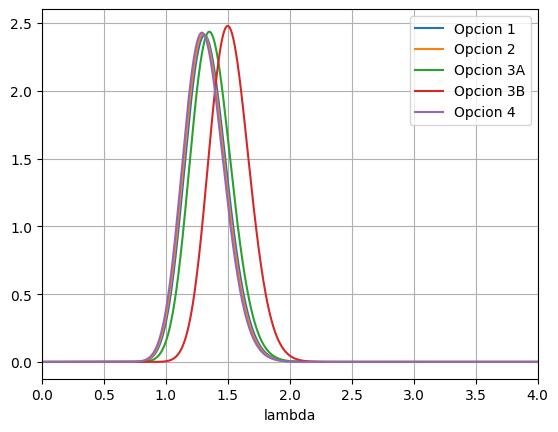

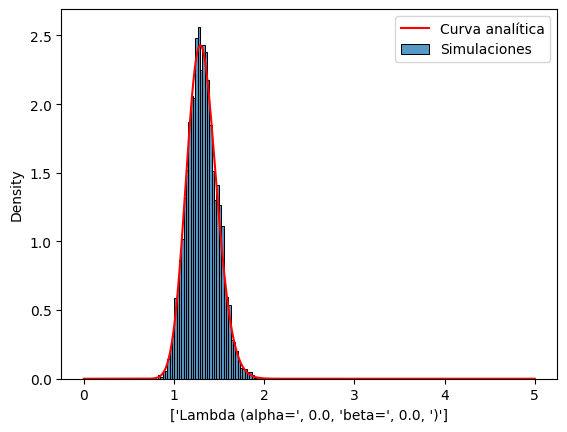

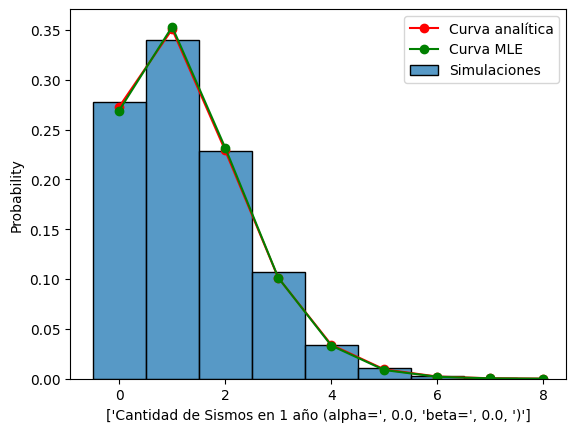

In [ ]:
# Parametros a priori (Gamma)
alpha = np.array([1, 0.5, 6.25, 25, 0])
beta = np.array([0, 0, 2.5, 10, 0])
labels = ["Opcion 1","Opcion 2","Opcion 3A","Opcion 3B","Opcion 4"]

for i in range(len(alpha)):
  # Parametros posteriores (Gamma)
  alpha_p = alpha[i] + sum_xi
  beta_p = beta[i] + sum_DT

# Soluciones analiticas
# ==============================================================================
  # Modelos analiticos de la solucion
  lam_an = st.gamma(alpha_p,scale=1/beta_p)
  X_an = st.nbinom(alpha_p,beta_p/(DT+beta_p))

  # Solucion Frecuentista
  X_f = st.poisson(sum_xi/sum_DT*DT)

  # Vector para la evaluacion
  ki = np.array(range(10000))/2000
  Xi = np.array(range(9))
  pli = lam_an.pdf(ki)
  pXi = X_an.pmf(Xi)
  pXf = X_f.pmf(Xi)
# ==============================================================================

  # Simulacion con Numpy
  N = 4800
  lam_sim = np.random.gamma(alpha_p,1/beta_p,N)
  X_sim = np.random.negative_binomial(alpha_p,beta_p/(DT+beta_p),N)

  plt.plot(ki,pli,label=labels[i])
  plt.legend()
  plt.grid()
  plt.xlim([0, 4])
  plt.xlabel('lambda')

plt.show()

sns.histplot(lam_sim,label='Simulaciones',stat='density')
plt.plot(ki,pli,label='Curva analítica',color='red')
plt.legend()
plt.xlabel(['Lambda (alpha=',alpha[i],'beta=',beta[i],')'])
plt.show()

sns.histplot(X_sim,label='Simulaciones',stat='probability',discrete=True)
plt.plot(Xi,pXi,label='Curva analítica',color='red',marker='o')
plt.plot(Xi,pXf,label='Curva MLE',color='green',marker='o')
plt.legend()
plt.xlabel(['Cantidad de Sismos en 1 año (alpha=',alpha[i],'beta=',beta[i],')'])
plt.show()

Como pueden ver, los resultados dan prácticamente lo mismo. ¿Qué pasa si lo hago para $\Delta t=50$?

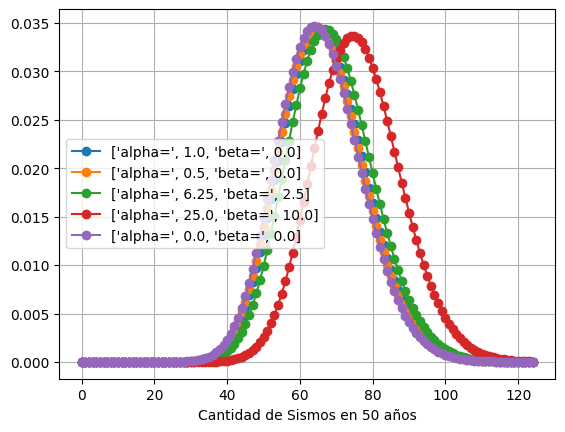

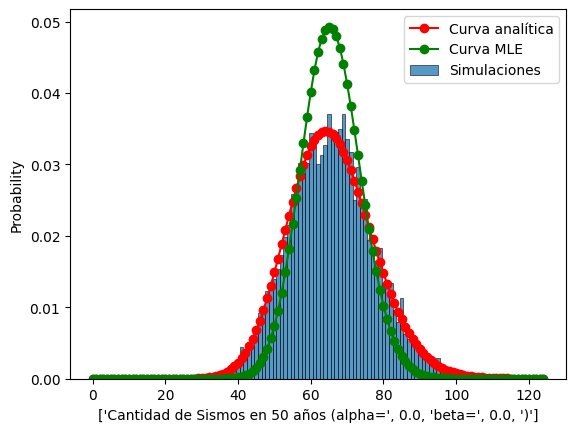

In [ ]:
# Intervalo para predicciones
DT = 50

# Parametros a priori (Gamma)
alpha = np.array([1, 0.5, 6.25, 25, 0])
beta = np.array([0, 0, 2.5, 10, 0])

for i in range(len(alpha)):
  # Parametros posteriores (Gamma)
  alpha_p = alpha[i] + sum_xi
  beta_p = beta[i] + sum_DT

# Soluciones analiticas
# ==============================================================================
  # Modelos analiticos de la solucion
  lam_an = st.gamma(alpha_p,scale=1/beta_p)
  X_an = st.nbinom(alpha_p,beta_p/(DT+beta_p))

  # Solucion Frecuentista
  X_f = st.poisson(sum_xi/sum_DT*DT)

  # Vector para la evaluacion
  ki = np.array(range(10000))/75
  Xi = np.array(range(125))
  pli = lam_an.pdf(ki)
  pXi = X_an.pmf(Xi)
  pXf = X_f.pmf(Xi)
# ==============================================================================

  # Simulacion con Numpy
  N = 4800
  lam_sim = np.random.gamma(alpha_p,1/beta_p,N)
  X_sim = np.random.negative_binomial(alpha_p,beta_p/(DT+beta_p),N)

  plt.plot(Xi,pXi,label=['alpha=',alpha[i],'beta=',beta[i]],marker='o')
  plt.legend()
  plt.grid()
  plt.xlabel('Cantidad de Sismos en 50 años')

plt.show()

sns.histplot(X_sim,label='Simulaciones',stat='probability',discrete=True)
plt.plot(Xi,pXi,label='Curva analítica',color='red',marker='o')
plt.plot(Xi,pXf,label='Curva MLE',color='green',marker='o')
plt.legend()
plt.xlabel(['Cantidad de Sismos en 50 años (alpha=',alpha[i],'beta=',beta[i],')'])
plt.show()

Noten, entonces, dos cosas interesantes. Por un lado, que todas nuestras distribuciones que intentaron aportar poca información dieron más o menos lo mismo. ¡Genial! Dejaron a los datos hablar, incluyendo la opción 3A.

A medida de que yo hago más informátiva a la distribución a priori (menos desvío, opción 3B), esta empieza a tener más importancia en la distribución posterior. Este efecto lo podemos ver graficando la distribución a priori, la posterior y alguna de las soluciones "no informativas" (como proxy de la función de verosimilitud) en un mismo esquema para las opciones 3A y 3B:

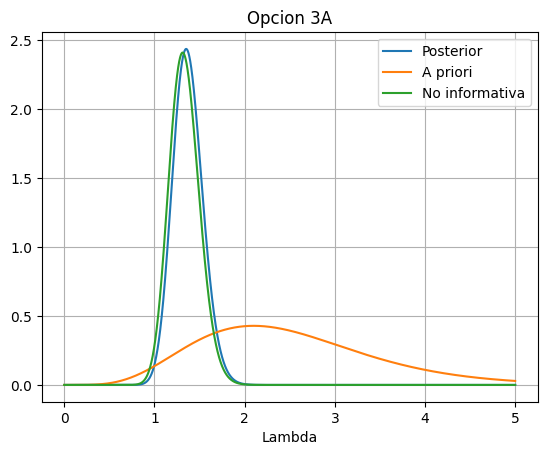

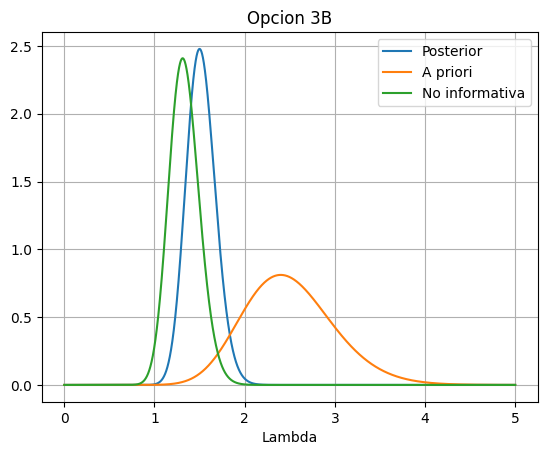

In [ ]:
# Parametros a priori (Gamma)
alpha = np.array([6.25, 25])
beta = np.array([2.5, 10])
labels = ["Opcion 3A", "Opcion 3B"]

for i in range(len(alpha)):
  # Parametros posteriores (Gamma)
  alpha_p = alpha[i] + sum_xi
  beta_p = beta[i] + sum_DT

# Soluciones analiticas
# ==============================================================================
  # Modelos analiticos de la priori
  lam_p = st.gamma(alpha[i],scale=1/beta[i])

  # Modelos analiticos de la solucion
  lam_an = st.gamma(alpha_p,scale=1/beta_p)

  # Solucion NO-informativa
  lam_ni = st.gamma(1+sum_xi,scale=1/sum_DT)

  # Vector para la evaluacion
  ki = np.array(range(10000))/2000
  pli = lam_an.pdf(ki)
  ppf = lam_p.pdf(ki)
  pni = lam_ni.pdf(ki)
# ==============================================================================

  plt.plot(ki,pli,label='Posterior')
  plt.plot(ki,ppf,label='A priori')
  plt.plot(ki,pni,label='No informativa')
  plt.plot()
  plt.legend()
  plt.grid()
  plt.xlabel('Lambda')
  plt.title(labels[i])
  plt.show()

Noten, además, como las estimaciones al usar distribuciones a priori más informativas tienen menos incertidumbre! *Sirve incluir información a mis problemas, no todo va entre 0 e infinito*.

#### Comentario respecto a la simulación de las distribuciones

Como comentario, si bien la distribución binomial negativa está cargada en Numpy, si no lo estuviese la simulación la podría hacer en forma jerárquica:

1. Simulo N veces valores de $\lambda$
2. Para cada valor de $\lambda$ simulo una vez el fenómeno de Poisson (porque el modelo de probabilidad condicional lo tengo).

Les mostramos ahora como quedaría (por ejemplo, para la Opcion 1):

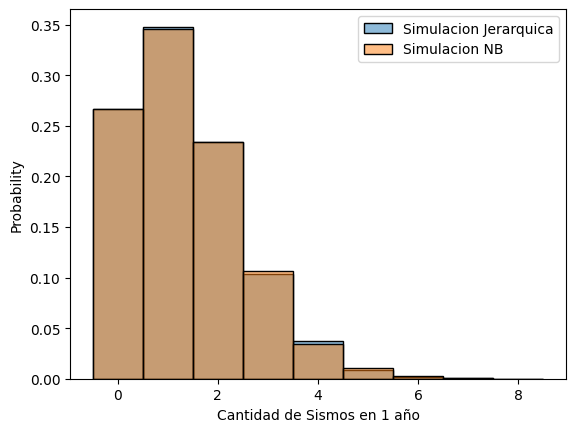

In [ ]:
# Simulacion con Numpy
N = 48000
lam_sim = np.random.gamma(1+sum_xi,1/sum_DT,N)

# Simulo X dado Lambda
X_sim2 = np.array([np.random.poisson(lx) for lx in lam_sim])

# Simulo NB de una
X_sim = np.random.negative_binomial(1+sum_xi,sum_DT/(1+sum_DT),N)

sns.histplot(X_sim2,label='Simulacion Jerarquica',stat='probability',discrete=True,alpha=0.5)
sns.histplot(X_sim,label='Simulacion NB',stat='probability',discrete=True,alpha=0.5)
plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

Como ven, ¡me dio lo mismo!

#### Evaluación de la predictiva

Lo que vimos antes es simplemente un chequeo de que nuestra simulación por Monte Carlo está dando lo mismo que la solución analítica (para ir entrando en la costumbre de trabajar en forma numérica). Pero en realidad poco me dice respecto a si lo que mi modelo predice se parece a los datos que medí.

Entonces, comparemos el histograma de datos con el histograma que nuestro modelo predice:

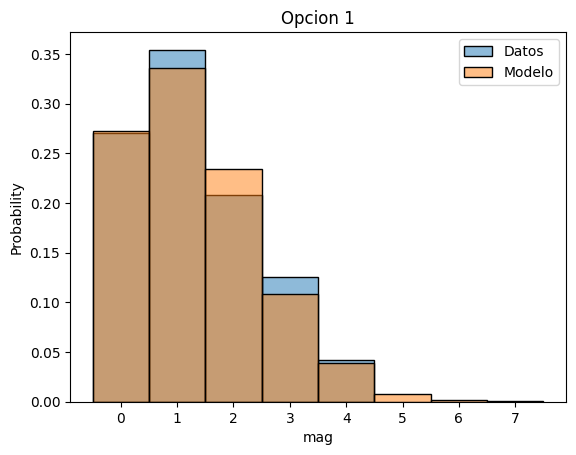

In [ ]:
# Simulo NB de una
N = 4800
X_sim = np.random.negative_binomial(1+sum_xi,sum_DT/(1+sum_DT),N)

sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',alpha=0.5)
sns.histplot(X_sim,discrete=True,stat='probability',label='Modelo',alpha=0.5)
plt.legend()
plt.title('Opcion 1')
plt.show()

A simple vista se parecen bastante (a futuro veremos más sobre como evaluar modelos y compararlos). Hagamos el mismo gráfico pero como líneas.

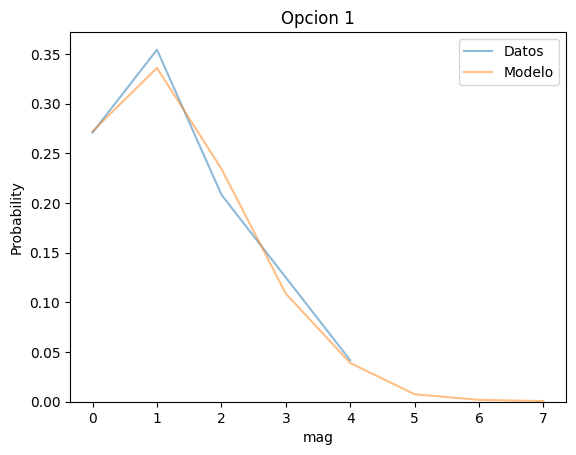

In [ ]:
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',alpha=0.5,element='poly',fill=False)
sns.histplot(X_sim,discrete=True,stat='probability',label='Modelo',alpha=0.5,element='poly',fill=False)
plt.legend()
plt.title('Opcion 1')
plt.show()

Ahora vamos a darle una pequeña vuelta de tuerca. En mi modelo, yo estoy mostrando el resultado de 4800 simulaciones, mientras que datos solo tengo 48.

¿Por qué no, entonces, agrupo mis simulaciones en combos de 48 simulaciones cada una? Es decir, ¡imaginemos que lo que hago es simular 100 veces el experimento que tengo! Eso nos va a permitir ver la variabilidad propia del experimento, y no solo el resultado final cuando considero *todas* las simulaciones.

Imaginense que puede pasar que en realidad nuestros 48 datos hayan sido algo poco probable de un modelo con parámetros relativamente distintos. Este tipo de gráficos no permite al menos pensar que tan distinto me podría haber dado (cuando hay suficientes datos, uno espera que las probabilidades según esos 100 experimentos simulados se parezcan a lo medido y a las probabilidades de considerar todos los experimentos --> **nuestra distribución predictiva**)

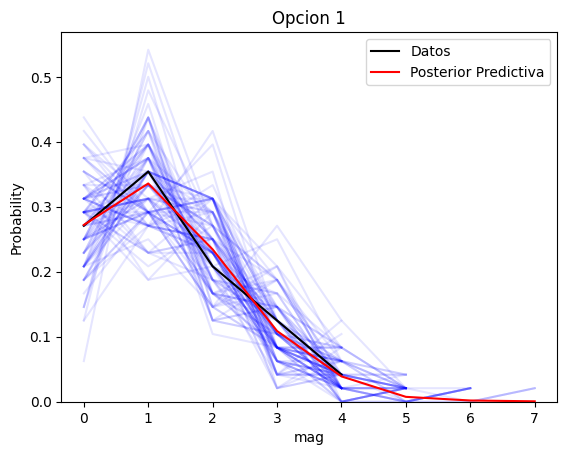

In [ ]:
# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(X_sim,(len(Data['mag']),-1))

# Grafico los 100 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(X_sim,discrete=True,stat='probability',label='Posterior Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Opcion 1')
plt.show()

¿Ven razonable los resultados? ¿Los datos parecen venir de una distribución de Poisson? ¿La cantidad de datos parece suficiente para justificarlo?

Hagamos lo mismo para la Opcion 3B (la que tenía una distribución más informativa).

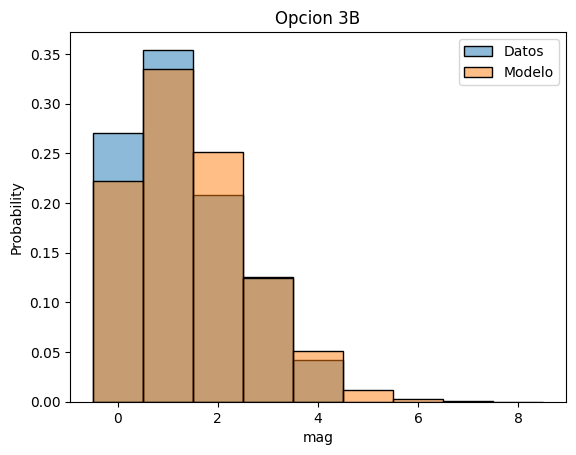

In [ ]:
# Simulo NB de una
N = 4800
X_sim = np.random.negative_binomial(25+sum_xi,(10+sum_DT)/(1+10+sum_DT),N)

sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',alpha=0.5)
sns.histplot(X_sim,discrete=True,stat='probability',label='Modelo',alpha=0.5)
plt.legend()
plt.title('Opcion 3B')
plt.show()

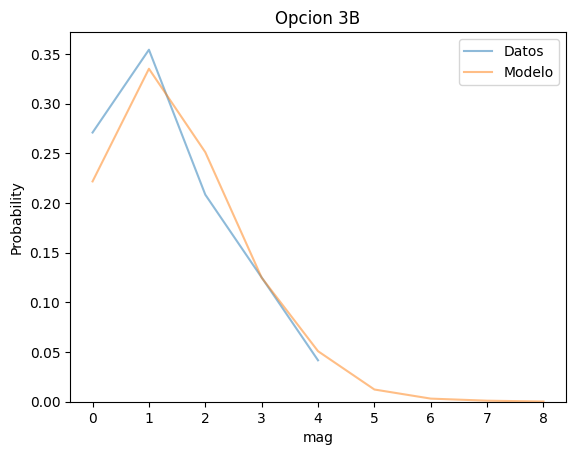

In [ ]:
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',alpha=0.5,element='poly',fill=False)
sns.histplot(X_sim,discrete=True,stat='probability',label='Modelo',alpha=0.5,element='poly',fill=False)
plt.legend()
plt.title('Opcion 3B')
plt.show()

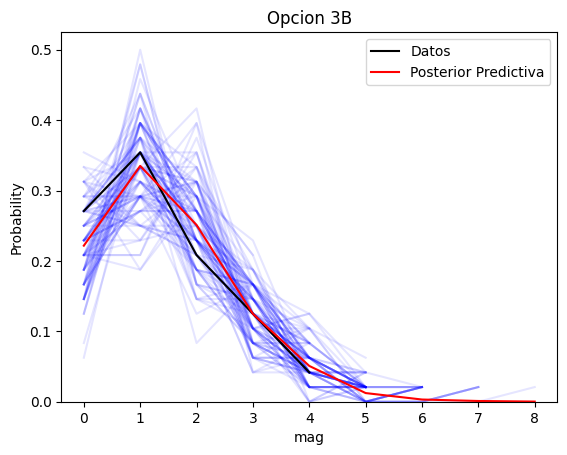

In [ ]:
# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(X_sim,(len(Data['mag']),-1))

# Grafico los 100 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(X_sim,discrete=True,stat='probability',label='Posterior Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Opcion 3B')
plt.show()

##### Un caso extremo

Como ven, lo que vi (los datos) siguen siendo una realización probable de mi modelo. ¿Pero qué pasa si llevo esto al absurdo?

Tomemos por ejemplo, una distribución a priori con valor medio 5 y desvío estandar 0.25. Es decir:

- $\beta = \frac{\bar{y}}{\sigma_{y}^{2}}=40$
- $\alpha = \bar{y}\beta=200$

¡Bueno, veamos! Claramente la posterior se va a parecer a la priori salvo que tenga **muchos** datos.

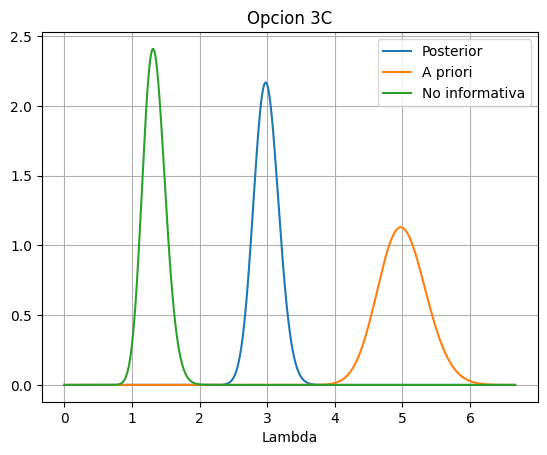

In [ ]:
# Parametros posteriores (Gamma)
alpha_p = 200 + sum_xi
beta_p = 40 + sum_DT

# Soluciones analiticas
# ==============================================================================
# Modelos analiticos de la priori
lam_p = st.gamma(200,scale=1/40)

# Modelos analiticos de la solucion
lam_an = st.gamma(alpha_p,scale=1/beta_p)

# Solucion NO-informativa
lam_ni = st.gamma(1+sum_xi,scale=1/sum_DT)

# Vector para la evaluacion
ki = np.array(range(10000))/1500
pli = lam_an.pdf(ki)
ppf = lam_p.pdf(ki)
pni = lam_ni.pdf(ki)
# ==============================================================================

plt.plot(ki,pli,label='Posterior')
plt.plot(ki,ppf,label='A priori')
plt.plot(ki,pni,label='No informativa')
plt.plot()
plt.legend()
plt.grid()
plt.xlabel('Lambda')
plt.title('Opcion 3C')
plt.show()

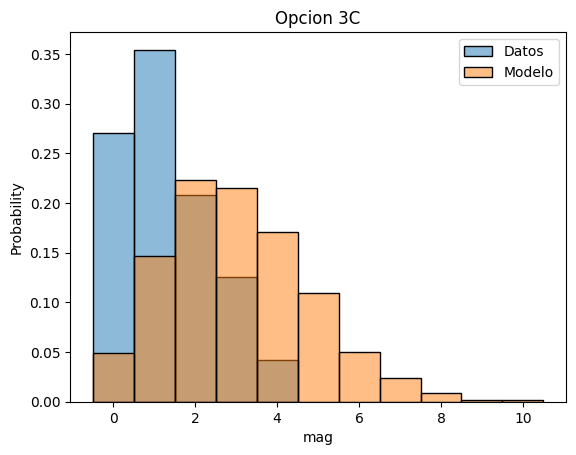

In [ ]:
# Simulo NB de una
N = 4800
X_sim = np.random.negative_binomial(200+sum_xi,(40+sum_DT)/(1+40+sum_DT),N)

sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',alpha=0.5)
sns.histplot(X_sim,discrete=True,stat='probability',label='Modelo',alpha=0.5)
plt.legend()
plt.title('Opcion 3C')
plt.show()

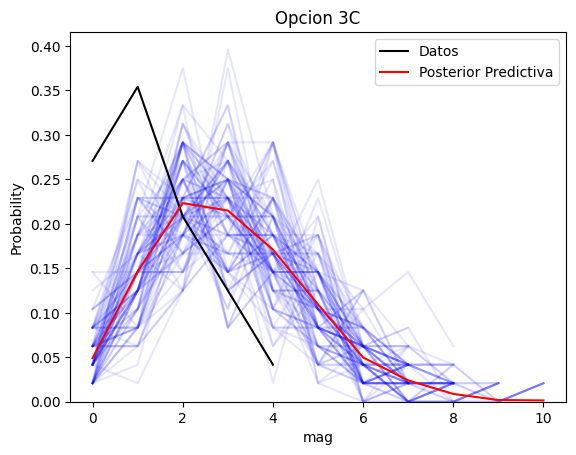

In [ ]:
# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(X_sim,(len(Data['mag']),-1))

# Grafico los 100 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(X_sim,discrete=True,stat='probability',label='Posterior Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Opcion 3C')
plt.show()

Viendo los resultados se desprende que los datos vistos son una realización prácticamente imposible de mi modelo. Esto me lleva a una situación algo absurda (¿los datos eran cualquier cosa entonces? ¿O es mi distribución a priori la que está mal?)

Si bien la distribución a priori es algo *subjetivo* del modelador, tampoco significa que se puede hacer "cualquier cosa". Mi modelo en este caso, por ejemplo, está básicamente negando los 48 años de datos que capturé. La curva negra debiera caer más o menos dentro de la nube azul para poder decir "bueno, mis datos pudieron haber pasado con este modelo".

Noten que no es lo mismo eso a decir que uno se parece más a la realidad que otro (filosóficamente)...

Más allá de eso, noten como uno puede con la distribución a priori incorporar cierta información previa para obtener mejores o menos inciertas estimaciones (Opción 3A y 3B por ejemplo). Son todos modelos razonables para los datos.

## Ejemplo 2: Sismos en San Juan (solución por MCMC)

Vimos antes un ejemplo en el que mi combinación de modelo de generación de datos y my distribución a priori me permitía encontrar soluciones analíticas para la distribución posterior de los parámetros y la posterior predictiva para predecir nuevos datos.

Ahora, el universo de problemas que puedo resolver de esa manera es acotado, y a lo largo del curso nos encontraremos numerosas veces con problemas que no tienen solución cerrada tan bonita. Para esos casos se utilizan modelos númericos mediante Cadenas de Markov para simular los resultados, que pueden no adherirse necesariamente a alguna función de distribución conocida con nombre propio.

En este curso, vamos a utilizar la librería `Bambi`, una versión más amigable con el usuario de `PyMC`, que permite muy rápidamente y de forma relativamente sencilla construir modelos y hacer inferencia.

Lo primero que vamos a hacer, entonces, es instalar e importar `Bambi` a Google Colab:

In [ ]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

# Import Arviz para ver los resultados
import arviz as az

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 MB/s eta 0:00:00


### Solución como modelo de Poisson

Supongamos ahora que queremos resolver el problema como modelo de Poisson. Construir un modelo en `Bambi` es relativamente sencillo, ya que tiene una nomenclatura similar a lo que se hace en otros programas como `R` y formatos de estadística clásica.

#### Construcción del modelo

Básicamente, un modelo se construye definiendo `bmb.model` donde se incluirá:

- La fórmula que explica a la variable (de qué depende), escrita en términos de los *nombres de las columnas* del DataFrame con los datos
- Qué DataFrame vamos a usar
- Qué tipo de modelo generación de datos se va a utilizar (por default está seteado el modelo Normal, pero puede ser uno Exponencial, de Poisson, Bernoulli, Binomial-Negativa, etc.)

En el caso de un ajuste de una función de distribución, el modelo "no tiene variables", así que la fórmula es constante:

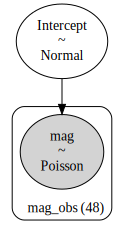

In [ ]:
# Construyo un modelo de poisson en Bambi
model_poisson = bmb.Model("mag ~ 1", Data,family='poisson')
model_poisson.build()

# Ver el modelo
model_poisson.graph()

#### Distribuciones a priori

Una cosa útil (pero no necesariamente didáctica) que tiene `Bambi` es que para los modelos que ya tiene cargados automáticamente (otros hay que incorporarlos a mano) es que ya define por vos distribuciones a priori poco-informativas de los parámetros.

Como mencionamos antes, no serán completamente no-informativas porque en general estas no son verdaderas distribuciones de probabilidad y no se pueden simular.

Más allá de eso, si tienen dudas pueden visualizar las distribuciones a priori del modelo con `plot_priors()`.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


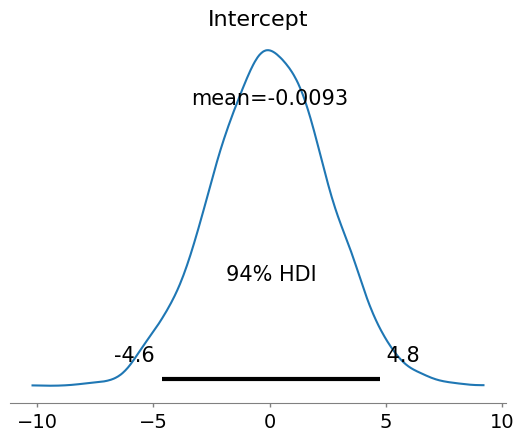

In [ ]:
# Grafico las distribuciones a priori
model_poisson.plot_priors()
plt.show()

Les puede parecer rara esta distribución a priori para $\lambda$ ya que se supone que solo toma valores positivos. ¡Pasa que `Bambi` usa como parámetro en realidad a $Ln(\lambda)$! Esto va a ser importante para comparar después.

Yo puedo (y debería) definir las distribuciones a priori que yo quiera. Recordemos que son decisión del modelador. Esto se hace con la opción `priors`.

Algunas distribuciones típicas son:

- La Normal para datos que toman cualquier valor (con desvío grande si queremos algo poco informativo)
- La HalfNormal o la Exponencial para datos positivos

Para este caso, Modelemos la Opción 3A del ejercicio anterior. Dijimos que teníamos como información a priori que la solución estaba entre 0.5 y 4.5.

Bueno, en escala logarítimica eso es decir que estamos entre -0.7 y 1.5 con media en 0.9. Por lo tanto, voy a adoptar a grandes rasgos.

$$p(\log{\lambda}) \sim N(0.9,0.4)$$

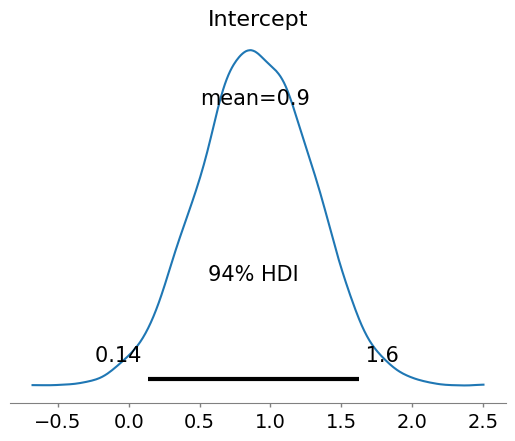

In [ ]:
# Modificacion de distribución a priori
priors = {"Intercept": bmb.Prior("Normal",mu=0.9,sigma=0.4)}

# Construyo un modelo de poisson en Bambi
model_poisson = bmb.Model("mag ~ 1", Data,family='poisson',priors=priors)
model_poisson.build()

# Mostrar Distribuciones a Priori
model_poisson.plot_priors()
plt.show()

Notarán que *yo* decidí incluir una distribución a priori mucho más informativa que `bambi`, que prácticamente aplicó el principio de indiferencia sobre el logaritmo de $\lambda$ con esa dispersión tan grande.

**Comentario**: Ninguna de estas distribuciones a priori lleva a una solución analítica, no queda otra que simular!

La pregunta que uno debiera hacerse siempre es, ¿estoy logrando lo que quiero con mis distribuciones a priori? No siempre es tan intuitivo!

Por ejemplo, si yo quería una distribución difusa, yo esperaría que el modelo "sin datos" arroje simulaciones que tomen un amplio rango de valores razonables. Por ejemplo, para sismos en San Juan si no tengo datos espero que mis distribuciones a priori devuelvan casi cualquier cosa entre 0 y 5 sismos por año sin introducir mucho bias (salvo que así lo quiera).

Esto se lo conoce como "Prior Check".

In [ ]:
 # Evaluacion de las distribuciones a priori
 results = model_poisson.prior_predictive()

Esta variable results es donde estaremos guardando todos nuestros resultados del modelo. Veamos qué tiene dentro:

In [ ]:
results

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Como ven, son simulaciones del intercept, y simulaciones de sismos por año asumiendo que no vi datos (es decir, usando solo la distribución a priori).

Verán que las simulaciones en `prior_predictive` tienen dimensiones (1,500,48). Eso es porque simulo 1 vez, 500 ensayos de 48 datos (de la misma dimensión que los datos observados). ¿Les suena? Lo habíamos usado en forma similar para evaluar la inferencia.

Veamos qué da. ¡La ventaja con Bambi es que este gráfico se hace solo!

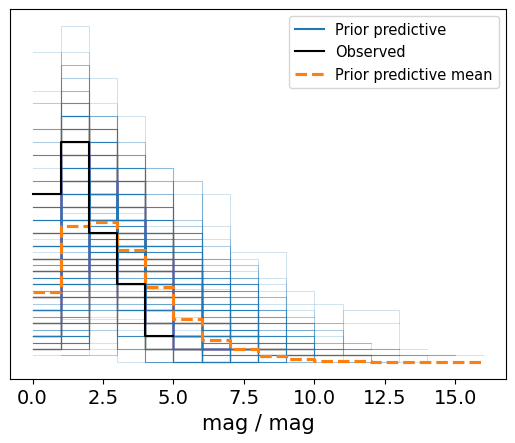

In [ ]:
# Prior Check con Bambi
az.plot_ppc(results,group='prior')
plt.show()

Como pueden ver, las distribuciones simuladas van desde casos donde hay 0 sismos por año la mayoría del tiempo a casos donde 6 sismos por año son muy probables. Pero tampoco va a hasta infinto, yo se que eso es imposible. Nuestra distribución a priori parecer ser bastante razonable y difusa.

**NOTA**: ¿Y si me quiero hacer yo el gráfico? ¡Puedo acceder a mano a los datos simulados! se encuentran en `prior_predictive`. Luego puedo manipularlos para hacer los gráficos que hice antes.

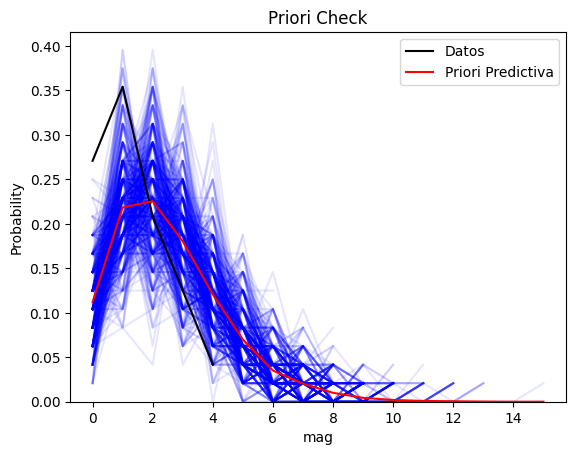

In [ ]:
# Accedo a los datos de las simulaciones
X_sim = results.prior_predictive['mag']

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim),(len(Data['mag']),-1))

# Grafico los 500 ensayos de 48 datos
for i in range(X_simG.shape[1]):
  sns.histplot(X_simG[:,i],discrete=True,stat='probability',label=None,color='blue',alpha=0.1,element='poly',fill=False)
sns.histplot(Data['mag'],discrete=True,stat='probability',label='Datos',color='black',element='poly',fill=False)
sns.histplot(np.ravel(X_sim),discrete=True,stat='probability',label='Priori Predictiva',color='red',element='poly',fill=False)
plt.legend()
plt.title('Priori Check')
plt.show()

Reconocer que `Bambi` siempre devuelve simulaciones es importante y la razón por la cual siempre venimos trabajando así en vez de con las funciones propiamente dicha, aún cuando había soluciones analíticas!

#### Realizar la inferencia estadística

¡Lo que queda nomás es hacer la inferencia! Y a que no se imaginan, se hace también con una línea de código.

Los parámetros que se pueden modificar son:

- El número de cadenas de markov: `chains`. Por default usa el valor más grande entre el número de núcleos de la PC y 2 (en colab, esto defaultea a 2). Esto es porque se pueden paralelizar y hacer más simulaciones en la misma cantidad de tiempo.
- El número de simulaciones en la cadena: `draws`. El default es 1000
- El número de iteraciones: `tune`. El default también es 1000
- Fijar la RNG para obtener resultados replicables: `random_seed`
-

Además se le puede agregar otros parámetros adicionales. Uno es que guarde los cálculos de log-verosimilitud (muy útil para la clase siguiente). Otro también es modificar el `target_accept` (default 0.8), en caso de que la cadena tenga problemas de convergencia esto puede ayudar.

In [ ]:
# Hago la inferencia estadística
results_poisson = model_poisson.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

**Nota**: El argumento `log_likelihood` es para que guarde los datos de log-verosimilitud, que pueden ser muy útiles.

Lo que sí tienen que prestar atención al hacer la inferencia es al resultado. **Siempre revisen que no haya divergencias**. De lo contrario tienen un problema (generalmente el modelo tiene alguna complicación, como pueden ser distirbuciones a priori mal definidas o incompatibles, etc.). A veces se puede subsanar aumentando el valor de `tune` or `target_accept`, si no es el problema el modelo en sí.

Es importante también visualizar qué ocurrió durante la inferencia. Para eso tenemos 2 herramientas, una visual y otra en forma de tabla:

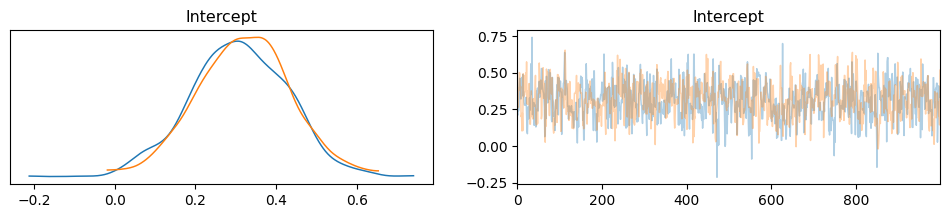

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.314,0.119,0.064,0.513,0.004,0.003,755.0,1244.0,1.0


In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_poisson, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_poisson)

Acá se podría entrar en mucho detalle, pero lo importante es que vean que las cadenas se parezcan entre sí y que pareciera haber independencia. En cuanto a la tabla, numéricamente el valor de `r_hat` debiera ser prácticamente 1, es decir que haya una buena correlación.

Si todo esto está OK, entonces la *inferencia está bien hecha* (no significa que el modelo sea bueno, son cosas distintas).

#### Distribuciones posteriores

De forma muy similar, podemos mirar entonces cuál es la distribución de los parámetros de nuestro modelo dado los datos observados. Noten que puedo elegir el intervalo de confianza a informar (por default es 0.94).

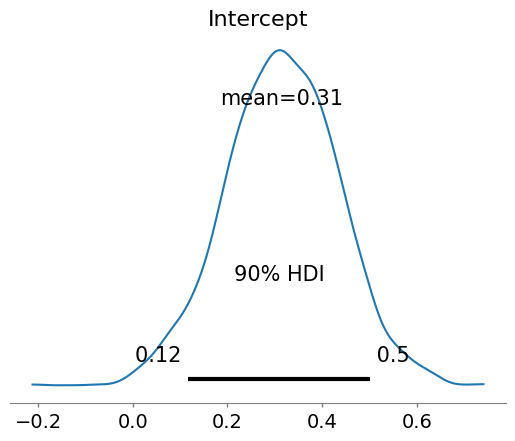

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.314,0.119,0.116,0.501,0.004,0.003,755.0,1244.0,1.0


In [ ]:
az.plot_posterior(results_poisson, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_poisson,hdi_prob=0.9)

Nota: `Bambi` resuelve el problema de Poisson en escala logarítmica, por lo que lo que ven ahí es el logarítmo del parámetro $\lambda$. Pueden chequear que $e^{0.3}\approx 1.35$, que es lo que esperabamos ver según los datos (y la influencia de la prior).

Y lo mismo con la posterior predictiva, la cual primer hay que generar pidiendo que haga predicciones en base a los resultados con `predict`

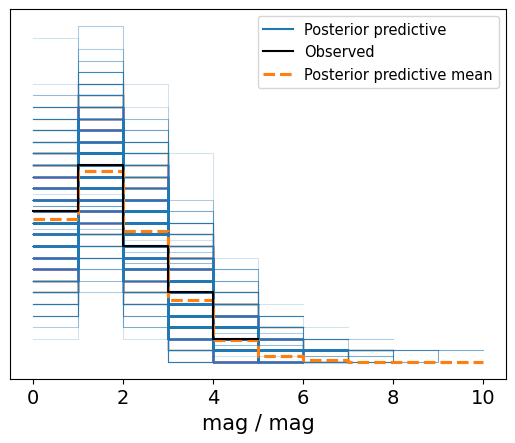

In [ ]:
# Hacer predicciones con mi modelo
model_poisson.predict(results_poisson,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_poisson)
plt.show()

Como ven, el gráfico se parece mucho al que construimos antes, con la diferencia de que en vez de 100 simulaciones del ensayo hay 4000. El resultado que después "me sirve" para predecir es ese promedio en amarillo.

Noten además como, comparado con el "prior check", las simulaciones ahora están mucho más acotadas alrededor de los datos.

#### Acceso a los resultados

Una pregunta que se pueden hacer y es válida es "dónde están los datos de las simulaciones" para poder trabajarlos, calcular probabilidades, o incluirlos como parte de otro proyecto de simulación. O, por ejemplo, para ver los datos del parámetro en la escala que me interesa y no logarítmica.

Bueno, para acceder a ellos veamos qué hay dentro de la variable que creamos con nombre `results_poisson`

In [ ]:
results_poisson

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Como pueden ver, en `posterior` pueden acceder a las simulaciones de los parámetros, y en `posterior_predictive` a las simulaciones de datos no-observados.

Pero van a notar algo raro, son arrays 3D! $(n,x,y)$. Bueno, esto es porque:
- $n$ son las cadenas de Markov que se usaron para la inferencia
- $x$ son la cantidad de simulaciones que se hicieron dentro de cada cadena de la muestra
- $y$ es la cantidad de muestras de mi dataset.

Es como hicimos antes, $n\cdot x$ réplicas de una muestra como la de los datos, que es lo veiamos en el gráfico anterior. La posterior predictiva es el promedio de todo eso. Para este caso, podemos calcularla agarrando todas las simulaciones y poniendolas en un solo vector con np.ravel por ejemplo.

Aprovechemos no sólo para hacer esto, sino también para volver a `intercept` a la escala que nos interesa, para comparar con nuestro modelo anterior.

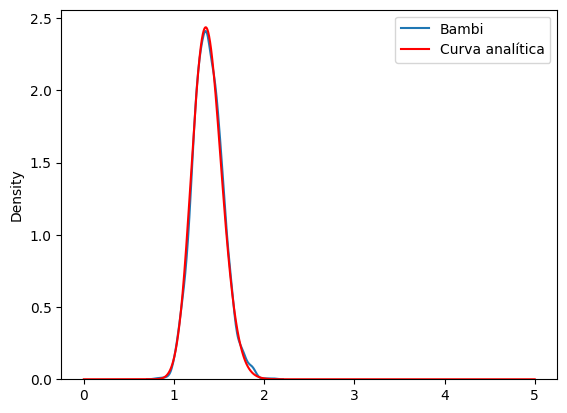

In [ ]:
# Simulaciones del parámetro
log_param = np.ravel(results_poisson.posterior['Intercept'])
param = np.exp(log_param)

# Solución analitica (Opcion 3A)
# ==============================================================================
alpha = 6.25
beta = 2.5
# Modelos analiticos de la solucion
lam_an = st.gamma(alpha+sum_xi,scale=1/(beta+sum_DT))
X_an = st.nbinom(alpha+sum_xi,(beta+sum_DT)/(1+(beta+sum_DT)))

# Vector para la evaluacion
ki = np.array(range(10000))/2000
Xi = np.array(range(9))
pli = lam_an.pdf(ki)
pXi = X_an.pmf(Xi)
# ==============================================================================

sns.kdeplot(param,label='Bambi')
plt.plot(ki,pli,label='Curva analítica',color='red')
plt.legend()
plt.show()

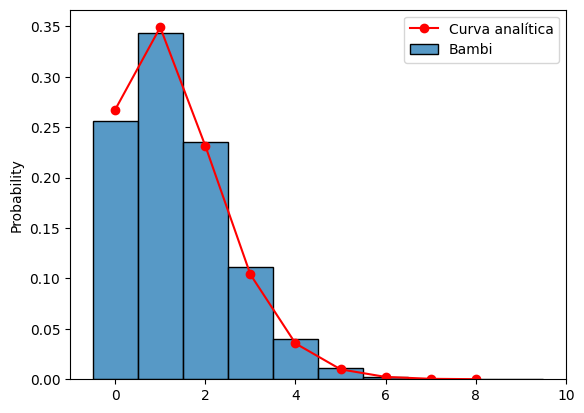

In [ ]:
# Simulaciones de sismos por año
y_post = np.ravel(results_poisson.posterior_predictive['mag'])
sns.histplot(y_post,discrete=True,stat='probability',label='Bambi')
plt.plot(Xi,pXi,label='Curva analítica',color='red',marker='o')
plt.legend()
plt.show()

¡Como ven, dio básicamente lo mismo! Tengan en mente siempre cómo pueden acceder a las simulaciones, ya sea para construir sus propios gráficos o para hacer los cálculos que necesiten.

### Solución lineal en $\lambda$

En la solución anterior vimos que por default `Bambi` hacer la inferencia y y ajusta el modelo para el logaritmo de $\lambda$. ¿Pero qué pasa si yo quiero hacerlo directamente para $\lambda$?

Bueno, para eso tengo que construir el modelo con un poco más de esfuerzo. Tendremos que definir:

- La función de verosimilitud (en este caso es Poisson)
- El link (en este caso es la identidad, yo escribo la cosas en términos del propio parámetro)
- Distribuciones a priori
- La fórmula del modelo

Se los mostramos en la forma más genérica posible para que vean que todo es modificable según lo necesario.


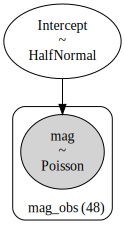

In [ ]:
# Construir Función de Verosimilitud ------------------------------
# El nombre tienen que ser una función que exista en PyMC
# 'parent' es la media de la distribucion (qué parametro tiene ese rol).
likelihood = bmb.Likelihood("Poisson", params=["mu"], parent="mu")

# Setear link ----------------------------------------------
link = {"mu": "identity"}

# Construir familia -------------------------------------------
family = bmb.Family("poisson_ICDIC", likelihood, link)

# Elegir Priors ------------------
priors = {"Intercept": bmb.Prior("HalfNormal",sigma=10)}

model_new = bmb.Model("mag ~ 1", Data, family=family,priors=priors)

# Ver el modelo
model_new.build()
model_new.graph()

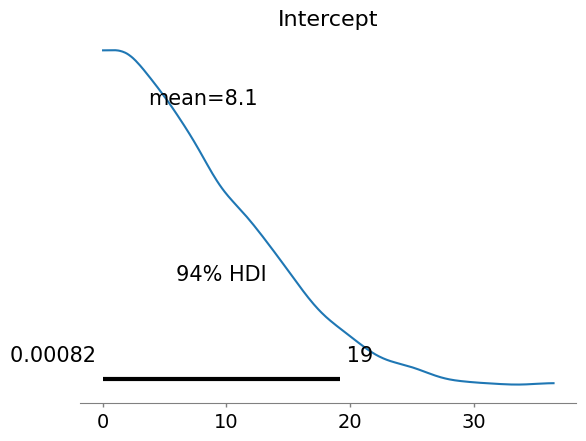

In [ ]:
# Grafico las distribuciones a priori
model_new.plot_priors()
plt.show()

Fijensé que en este caso adopté una distribución poco-informativa.

In [ ]:
 # Evaluacion de las distribuciones a priori
 results = model_new.prior_predictive()

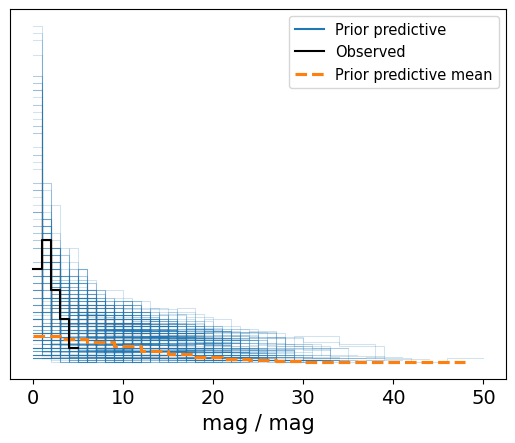

In [ ]:
# Prior Check con Bambi
az.plot_ppc(results,group='prior')
plt.show()

Tan no-informativa es que me puede dar cualquier cosa!

In [ ]:
# Hago la inferencia estadística
results_new = model_new.fit(chains=2,draws=1000,tune=1000,random_seed=10,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

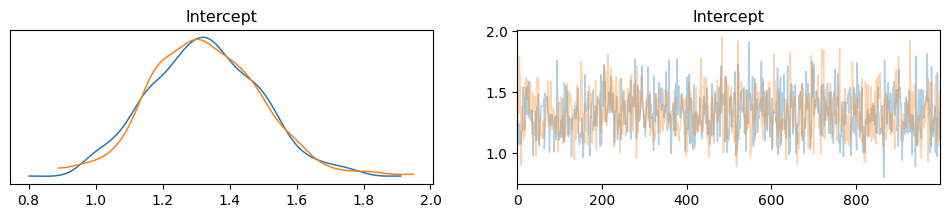

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.329,0.167,0.999,1.626,0.006,0.004,881.0,1239.0,1.0


In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results_new, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results_new)

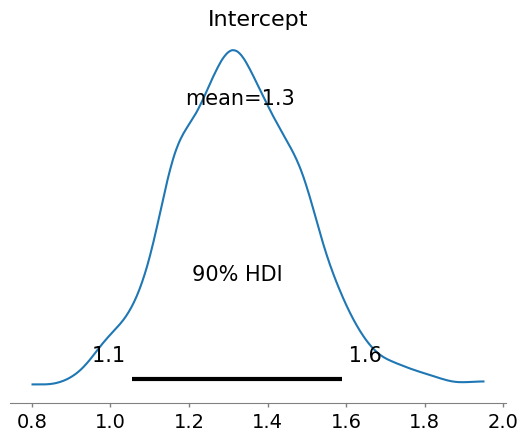

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.329,0.167,1.055,1.59,0.006,0.004,881.0,1239.0,1.0


In [ ]:
az.plot_posterior(results_new, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results_new,hdi_prob=0.9)

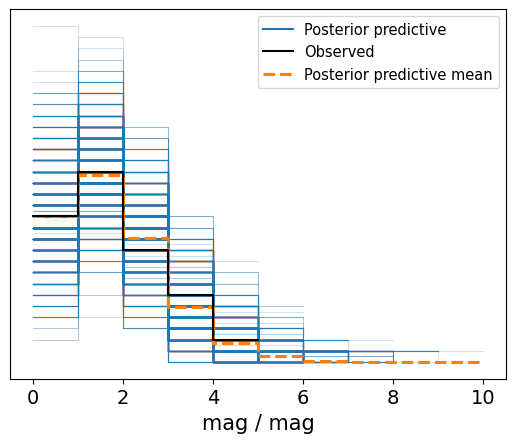

In [ ]:
# Hacer predicciones con mi modelo
model_new.predict(results_new,kind='pps')

# Visualizar predicciones
az.plot_ppc(results_new)
plt.show()

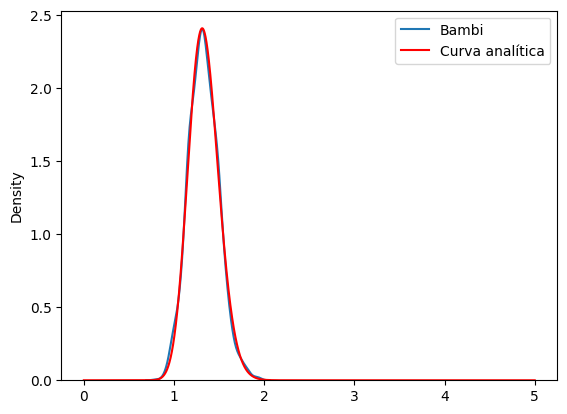

In [ ]:
# Simulaciones del parámetro
param_new = np.ravel(results_new.posterior['Intercept'])

# Solución analitica (Opcion 1)
# ==============================================================================
alpha = 1
beta = 0
# Modelos analiticos de la solucion
lam_an = st.gamma(alpha+sum_xi,scale=1/(beta+sum_DT))
X_an = st.nbinom(alpha+sum_xi,(beta+sum_DT)/(1+(beta+sum_DT)))

# Vector para la evaluacion
ki = np.array(range(10000))/2000
Xi = np.array(range(9))
pli = lam_an.pdf(ki)
pXi = X_an.pmf(Xi)
# ==============================================================================

sns.kdeplot(param_new,label='Bambi')
plt.plot(ki,pli,label='Curva analítica',color='red')
plt.legend()
plt.show()

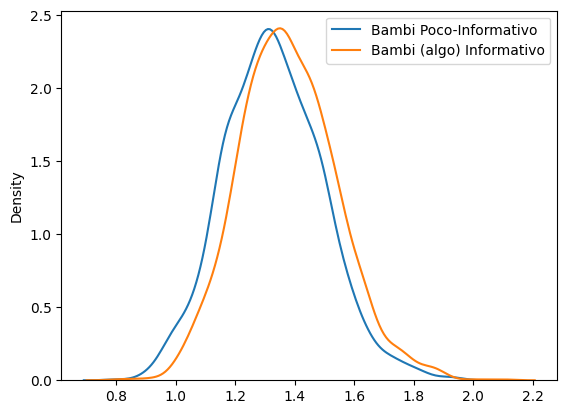

In [ ]:
sns.kdeplot(param_new,label='Bambi Poco-Informativo')
sns.kdeplot(param,label='Bambi (algo) Informativo')
plt.legend()
plt.show()

Como ven entonces, me dio básicamente lo mismo que antes. Así que con esto ya vimos cómo funciona `Bambi`, la capacidad que tiene de resolver por simulaciones problemas aún sin solución analítica, y cómo elegir distribuciones a priori razonables para el problema.

## Ejercicio 1: Jugando con probabilidad y simulaciones (Ayuda para TP2)

Para cerrar, me gustaría que usemos los datos simulados del modelo ajustado para contestar algunas preguntas con Monte Carlo.

Retomemos las simulaciones que hicimos para $\lambda$ y $X$.

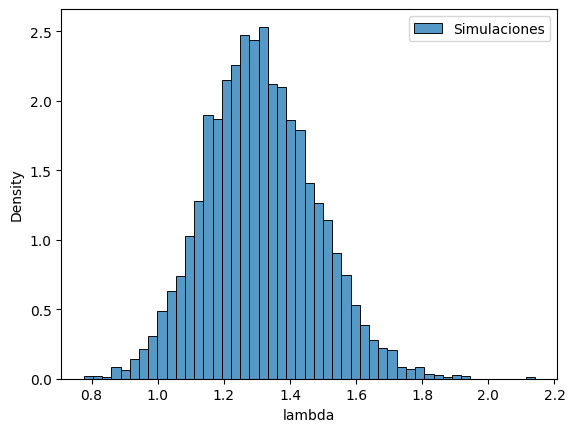

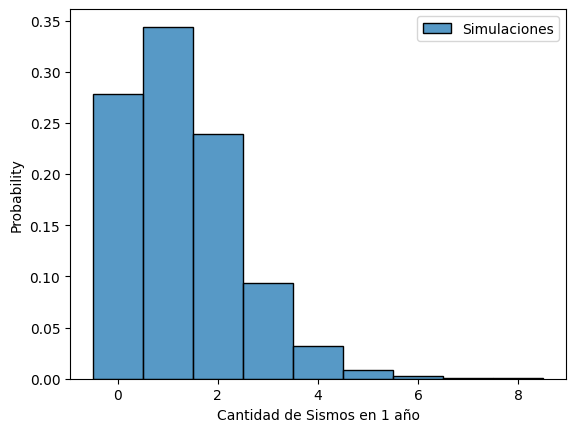

In [ ]:
# Simulacion con Numpy
N = 4000
lam_sim = np.random.gamma(sum_xi,1/n,N)
X_sim = np.random.negative_binomial(sum_xi,n/(1+n),N)

sns.histplot(lam_sim,label='Simulaciones',stat='density')
plt.legend()
plt.xlabel('lambda')
plt.show()

sns.histplot(X_sim,label='Simulaciones',stat='probability',discrete=True)
plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

Me gustaría que contestemos las siguientes preguntas.

1. ¿Cuál es la probabilidad de que haya más de 1 sismo en 1 año?
2. ¿Cuál es la probabilidad de que no haya sismos en los próximos 5 años?
3. ¿Cuál es la probabilidad de que $\lambda\leq1$
4. ¿Cuál es el percentil 90% de $\lambda$?
5. ¿Cuál es la probabilidad de que $\lambda\leq1$ dado que no se registraron sismos en un año?
6. Construya la funciones de probabilidad acumulada para ambos casos.

Recuerden, ¡son todos problemas de conteo como vimos la clase pasada!

Solucion 1: 0.378
Solucion 2: 0.0016604430303680008
Solucion 3: 0.02425
Solucion 4: 1.529297874855367
Solucion 5: 0.029676258992805755


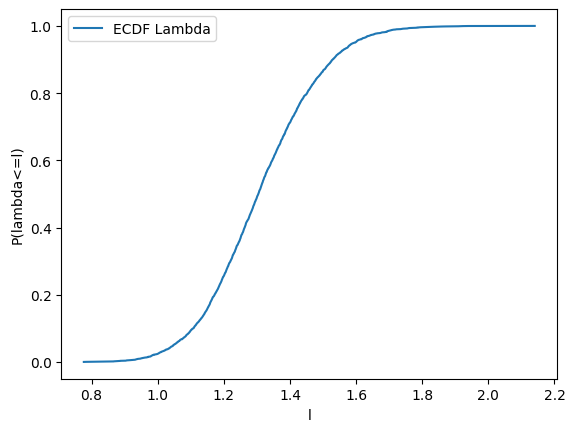

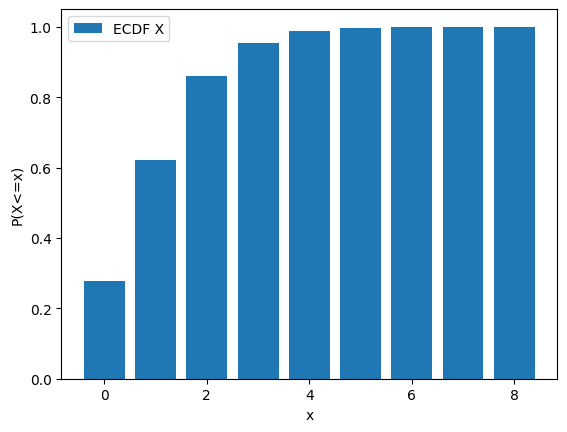

In [ ]:
# Solucion 1: Cuento cuántas veces
S1 = np.mean(X_sim>1)
print('Solucion 1:',S1)

# Solucion 2: para que no haya sismos en 5 años no puede haber sismos en ningun año (son independientes)
S2 = np.mean(X_sim==0) # probabilidad que no haya sismos en 1 ano
S2 = S2**5 # me tiene que pasar 5 anos seguidos
print('Solucion 2:',S2)

# Solución 3: Conteo
S3 = np.mean(lam_sim<=1)
print('Solucion 3:',S3)

# Solución 4: Me construyo la probabilidad acumulada
# Ordeno valores
l_sort = np.sort(lam_sim)
# Calculo la p(lam<=l_sort)
l_ECDF = np.array([np.mean(lam_sim<=li) for li in l_sort])
# Hallo el valor que cumple
S4 = np.min(l_sort[l_ECDF>=0.9])
print('Solucion 4:',S4)

# Solución 5: Es un conteo acotado a la condicion
# Subselecciono simulaciones
sel = X_sim==0
# Hago el conteo dentro de la seleccion
S5 = np.mean(lam_sim[sel]<=1)
print('Solucion 5:',S5)

# Solucion 6: Curva empirica (hago la que me falta)
X_sort = np.unique(np.sort(X_sim))
X_ECDF = np.array([np.mean(X_sim<=xi) for xi in X_sort])

plt.plot(l_sort,l_ECDF,label='ECDF Lambda')
plt.xlabel('l')
plt.ylabel('P(lambda<=l)')
plt.legend()
plt.show()

plt.bar(X_sort,X_ECDF,label='ECDF X')
plt.xlabel('x')
plt.ylabel('P(X<=x)')
plt.legend()
plt.show()

## Ejercicio 2: Jugando con teoría de probabilidad y Bayes (Ayuda para TP2)
Este ejercicio (adaptado del libro de James Goulet: [Link](https://profs.polymtl.ca/jagoulet/Site/Goulet_web_page_BOOK.html)) es simple en el sentido de que su solución analítica no es más que un par de productos y divisiones, y ayuda a entender un poco más cómo funciona la inferencia estadística (y es una excusa para aplicar el Teorema de Bayes).

Supongamos que entramos en una sala de teatro en el instante $t_{0}$. En el instante $t_{1}$ Suena la alarma. ¿Cuál es la probabilidad de que haya un incendio? En un instante $t_{2}$ se puede ver humo. ¿Cuál es la probabilidad de que haya un incendio?

### Probabilidad de que haya un incendio en un instante $t_{0}$

Sin saber nada, digamos que $P(I_{t0}=1)=0.01$. De donde se desprende que $P(I_{t0}=0)=0.99$.



In [ ]:
# Probabilidad de incendio en el instante t0
P_I_t0 = 0.01

### Probabilidad de que haya un incendio en un instante $t_{i+1}$

La pregunta es, ¿cómo evoluciona la probabilidad de incendio en el tiempo?

Para este ejercicio, supongamos que alguien estudió como se propagan los incendios y tenemos que:

- Si $I_{ti}=1$, entonces $P(I_{ti+1}=1|I_{ti}=1)=1$. Es decir, si había fuego hace un rato la probabilidad de que el incendio siga es 1 (no hay forma de que se apague).
- Según lo de antes, tomemos que la probabilidad que haya un incendio ahora si hace un rato no lo había es 0.01. $P(I_{ti+1}=1|I_{ti}=0)=0.01$. Es decir, no me da información nueva que antes no había un incendio porque es algo espontáneo.

De lo de arriba se desprenden los casos que faltan de probabilidad condicional:

- $P(I_{ti+1}=0|I_{ti}=0)=0.01$
- $P(I_{t1+1}=0|I_{ti}=1)=0$

In [ ]:
# Probabilidad de incendio en el instante t1 dado incendio en el instante t0
P_I_t1_I_t0 = 1

# Probabilidad de incendio en el instante t1 dado NO-incendio en el instante t0
P_I_t1_NI_t0 = 0.01

### Probabilidad de que haya un incendio en un instante $t_{1}$

La pregunta entonces, ¿cómo puedo usar los datos de arriba para encontrar la probabilidad de incendio en el tiempo $t_{1}$?

Podríamos usar probabilidad total:

$$P(I_{t1}=1) = P(I_{t1}=1|I_{t0}=1)P(I_{t0}=1)+P(I_{t1}=1|I_{t0}=0)P(I_{t0}=0)$$

In [ ]:
# Probabilidad de incendio en instante t1
P_I_t1 = P_I_t1_I_t0*P_I_t0 + P_I_t1_NI_t0*(1-P_I_t0)

print('La probabilidad de incendio en el instante t1 es:',P_I_t1)

La probabilidad de incendio en el instante t1 es: 0.0199


Noten que la probabilidad de incendio en el instante $t1$ es mayor al de $t0$. Es decir, cada vez es más probable que haya un incendio porque eventualmente alguno va haber y nunca se apaga. Fijense igual, que siempre que yo mire que en el instante anterior no había un incendio la probabilidad vuelve a mi caso original, como si el problema se resetease.

### Probabilidad de que haya un incendio en $t_{1}$ dado que suena la alarma (en $t_{1}$)

Imaginensé ahora que suena la alarma. ¿Cuál es la probabilidad de que haya un incendio?

Asumamos que la alarma del teatro tiene un 95% de eficacia en detectar incendios y un 5% de falsos positivos. Es decir:

- La probabilidad de alarma dado un incendio es $P(A=1|I_{ti}=1)=0.95$
- La probabilidad de alarma dado que no hay incendio es $P(A=1|I_{ti}=0)=0.05$

Nota: Es casualidad que estos datos sumen 1.

In [ ]:
# Probabilidad de alarma dado incendio en t1
P_A_I_t1 = 0.95

# Probabilidad de alarma dado NO-incendio en t1
P_A_NI_t1 = 0.05

El objetivo de este problema entonces es contestar la siguiente pregunta:

*¿Cuál es la probabilidad de que haya un incendio si suena la alarma?*

Bueno, por el Teorema de Bayes esto sería:

$$P(I_{t1}=1|A=1) = \frac{P(A=1|I_{t1}=1)\ P(I_{t1}=1)}{\sum P(A=1|I_{t1}=x)\ P(I_{t1}=x)}$$

Entonces:



In [ ]:
# Probabilidad de incendio en instante t1 dado que sonó la alarma
P_I_t1_A = P_A_I_t1*P_I_t1/(P_A_I_t1*P_I_t1+P_A_NI_t1*(1-P_I_t1))

print('La probabilidad de incendio en el instante t1 dado que sonó la alarma es:',P_I_t1_A)

La probabilidad de incendio en el instante t1 dado que sonó la alarma es: 0.27838315417464293


¡¡¡Es decir, suena la alarma y la chance de que realmente haya un incedio es 30%!!! Por eso ven ustedes que en general no hay mucho pánico cuando suena una alarma de incendio.




### Probabilidad de que haya un incendio en $t_{2}$ dado que sonó la alarma (en $t_{1}$)

Esto es muy parecido a lo que ya hicimos antes, podemos aplicar probalidad total. Esto será:

$$P(I_{t2}=1|A=1)=P(I_{t2}=1|I_{t1}=1)P(I_{t1}=1|A=1)+P(I_{t2}=1|I_{t1}=0)P(I_{t1}=0|A=1) $$

Donde estamos suponiendo que $P(I_{t2}=x|I_{t1}=y,A=1)=P(I_{t2}=x|I_{t1}=y)$ Es decir que la evolución de los incendios es condicionalmente independiente de la alarma, lo cual es lógico.

In [ ]:
# Probabilidad de incendio en instante t2 dado que sonó la alarma
P_I_t2_A = P_I_t1_I_t0*P_I_t1_A+P_I_t1_NI_t0*(1-P_I_t1_A)

print('La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1:',P_I_t2_A)

La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1: 0.2855993226328965


¡Apenas superior al dato anterior!

### Probabilidad de que haya un incendio dado que ahora se ve humo en $t_{2}$

Imaginensé ahora que vemos humo en el teatro. ¿Cuál es la probabilidad de que haya un incendio?

Asumamos que se puede ver humo en el 95% de los incendios, y que si no hay incendio la probabilidad de ver humo es 5%. Es decir:

- La probabilidad de humo dado un incendio es $P(H=1|I_{ti}=1)=0.95$
- La probabilidad de humo dado que no hay incendio es $P(H=1|I_{ti}=0)=0.05$

Nota: Es casualidad que estos datos sumen 1.

In [ ]:
# Probabilidad de humo dado incendio en t2
P_H_I_t2 = 0.95

# Probabilidad de humo dado NO-incendio en t2
P_H_NI_t2 = 0.05


¡Apliquemos el Teorema de Bayes otra vez! Asumiendo que el humo y la alarma no interactuan, nos queda:

$$P(I_{t2}|A=1,H=1) = \frac{P(H=1|I_{t2}=1)P(I_{t2}=1|A=1)}{\sum P(H=1|I_{t2}=x)P(I_{t2}=x|A=1)}$$

Noten que lo que estamos haciendo es invertir el orden entre las condicionales Humo e Incendio, La alarma me queda siempre como condicional. Simplifqué la nomenclatura considerando que:

$$P(H=1|I_{t2}=1,A=1)=P(H=1|I_{t2}=1)$$

Es decir, que la relación humo - incendio es condicionalmente independiente de la alarma

In [ ]:
# Probabilidad de incendio en instante t2 dado que sonó la alarma y se vio humo
P_I_t2_A_H = P_H_I_t2*P_I_t2_A/(P_H_I_t2*P_I_t2_A+P_H_NI_t2*(1-P_I_t2_A))

print('La probabilidad de incendio en el instante t2 dado que sonó la alarma en t1 y se vio humo en t2 es:',P_I_t2_A_H)

La probabilidad de incendio en el instante t2 dado que sonó la alarma y se vio humo es: 0.8836630250426298


¡Ahora sí salgo corriendo! Fijensé entonces como la probabilidad de incendio se fue actualizando en función de la información. Y vean cómo este ejercicio es un simple modelito de algo que vemos a diario (nadie se asusta si suena la alarma de incendio en general porque no logra vencer la sensación de que hay pocas probabilidades de incendio, pero si además noto humo ahora siento el incendio mucho más cerca)

## Ejercicio 3: Simulación de una distribución t-student (ayuda para el TP2)

Para ayudarlos con el TP2, les dejamos aquí un ejemplo cómo simular en Numpy una distribución t-student no estandarizada. Imaginensé que tienen una Variable Aleatoria $X$ gobernada por:

$$X \sim student-t(\nu,\mu,\tau)$$

también la van a encontrar como $t_{\nu}(\mu,\tau)$

- $\nu$ se refiere a los "grados de libertad" (¿se acuerdan de Probabilidad y Estadística? Cuando $\nu→∞$ entonces la t-student se transforma en una distribución normal)
- $\mu$ es el valor medio de la distribución o factor de ubicación
- $\tau$ es el factor de escala, cumple el mismo rol que el desvío estándar en la función (dividiendo a la variable), pero eso no quiere decir *que sea igual al desvío estandar*. Eso solo ocurre cuando $\nu→∞$

El problema que tenemos es que Numpy sólo tiene disponible para simular a la t-student standard ($\mu=0$, $\tau=1$). Entonces, para simularla vamos a tener que hacer una transformación de variables. Si

$$Z = \frac{X-\mu}{\tau}$$

¡Entonces $Z$ es una distribución t-standard (por eso se llaman factores de locación y escala)!

$$X \sim standard-t(\nu)$$

también la van a encontrar como $t_{\nu}$

El proceso consiste entones en:
1. Simular $Z$ como t-standard con $\nu$ grados de libertad
2. Calcular $X=Z*\tau+\mu$

¡Abajo les dejamos un ejemplo! Ustedes sabrán como adaptarlo al problema de inferencia estadística que tienen que resolver.

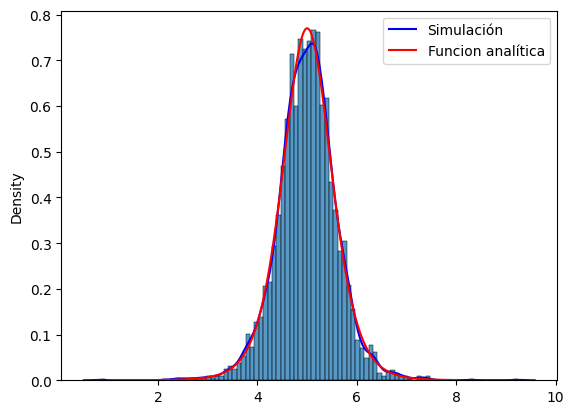

In [ ]:
mu = 5
tau = 0.5
nu = 7

# Simulaciones
N = 4000

# Simulo Z
Z = np.random.standard_t(nu,N)
# Transformo a X
X = Z*tau+mu

# Funcion analitica para chequear
tmodel = st.t(nu,loc=mu,scale=tau)
xi = np.array(range(1000,8000))/1000
ti = tmodel.pdf(xi)

## Grafico
sns.histplot(X,stat='density')
sns.kdeplot(X,label='Simulación',color='blue')
plt.plot(xi,ti,label='Funcion analítica',color='red')
plt.legend()
plt.show()